## ANALISIS BCP

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import os


In [2]:
#Carregando os dados
pasta_dados = os.listdir("../input")
df = pd.read_csv('../input/dados.csv')

In [3]:
#Conhecendo os dados 
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Para crear una visualización de los datos y ver qué características están relacionadas, podemos generar tablas de disimilitud, pero primero necesitamos trabajar con los datos, ya que hay tablas con atributos nominales.

In [4]:
df_2 = pd.get_dummies(df)
df_2.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


Podemos ver que tenemos 61 columnas, hay muchos atributos, podemos averiguar cuáles son los más relevantes para nuestra agrupación en función de una matriz de correlación.

**Matriz de correlación**

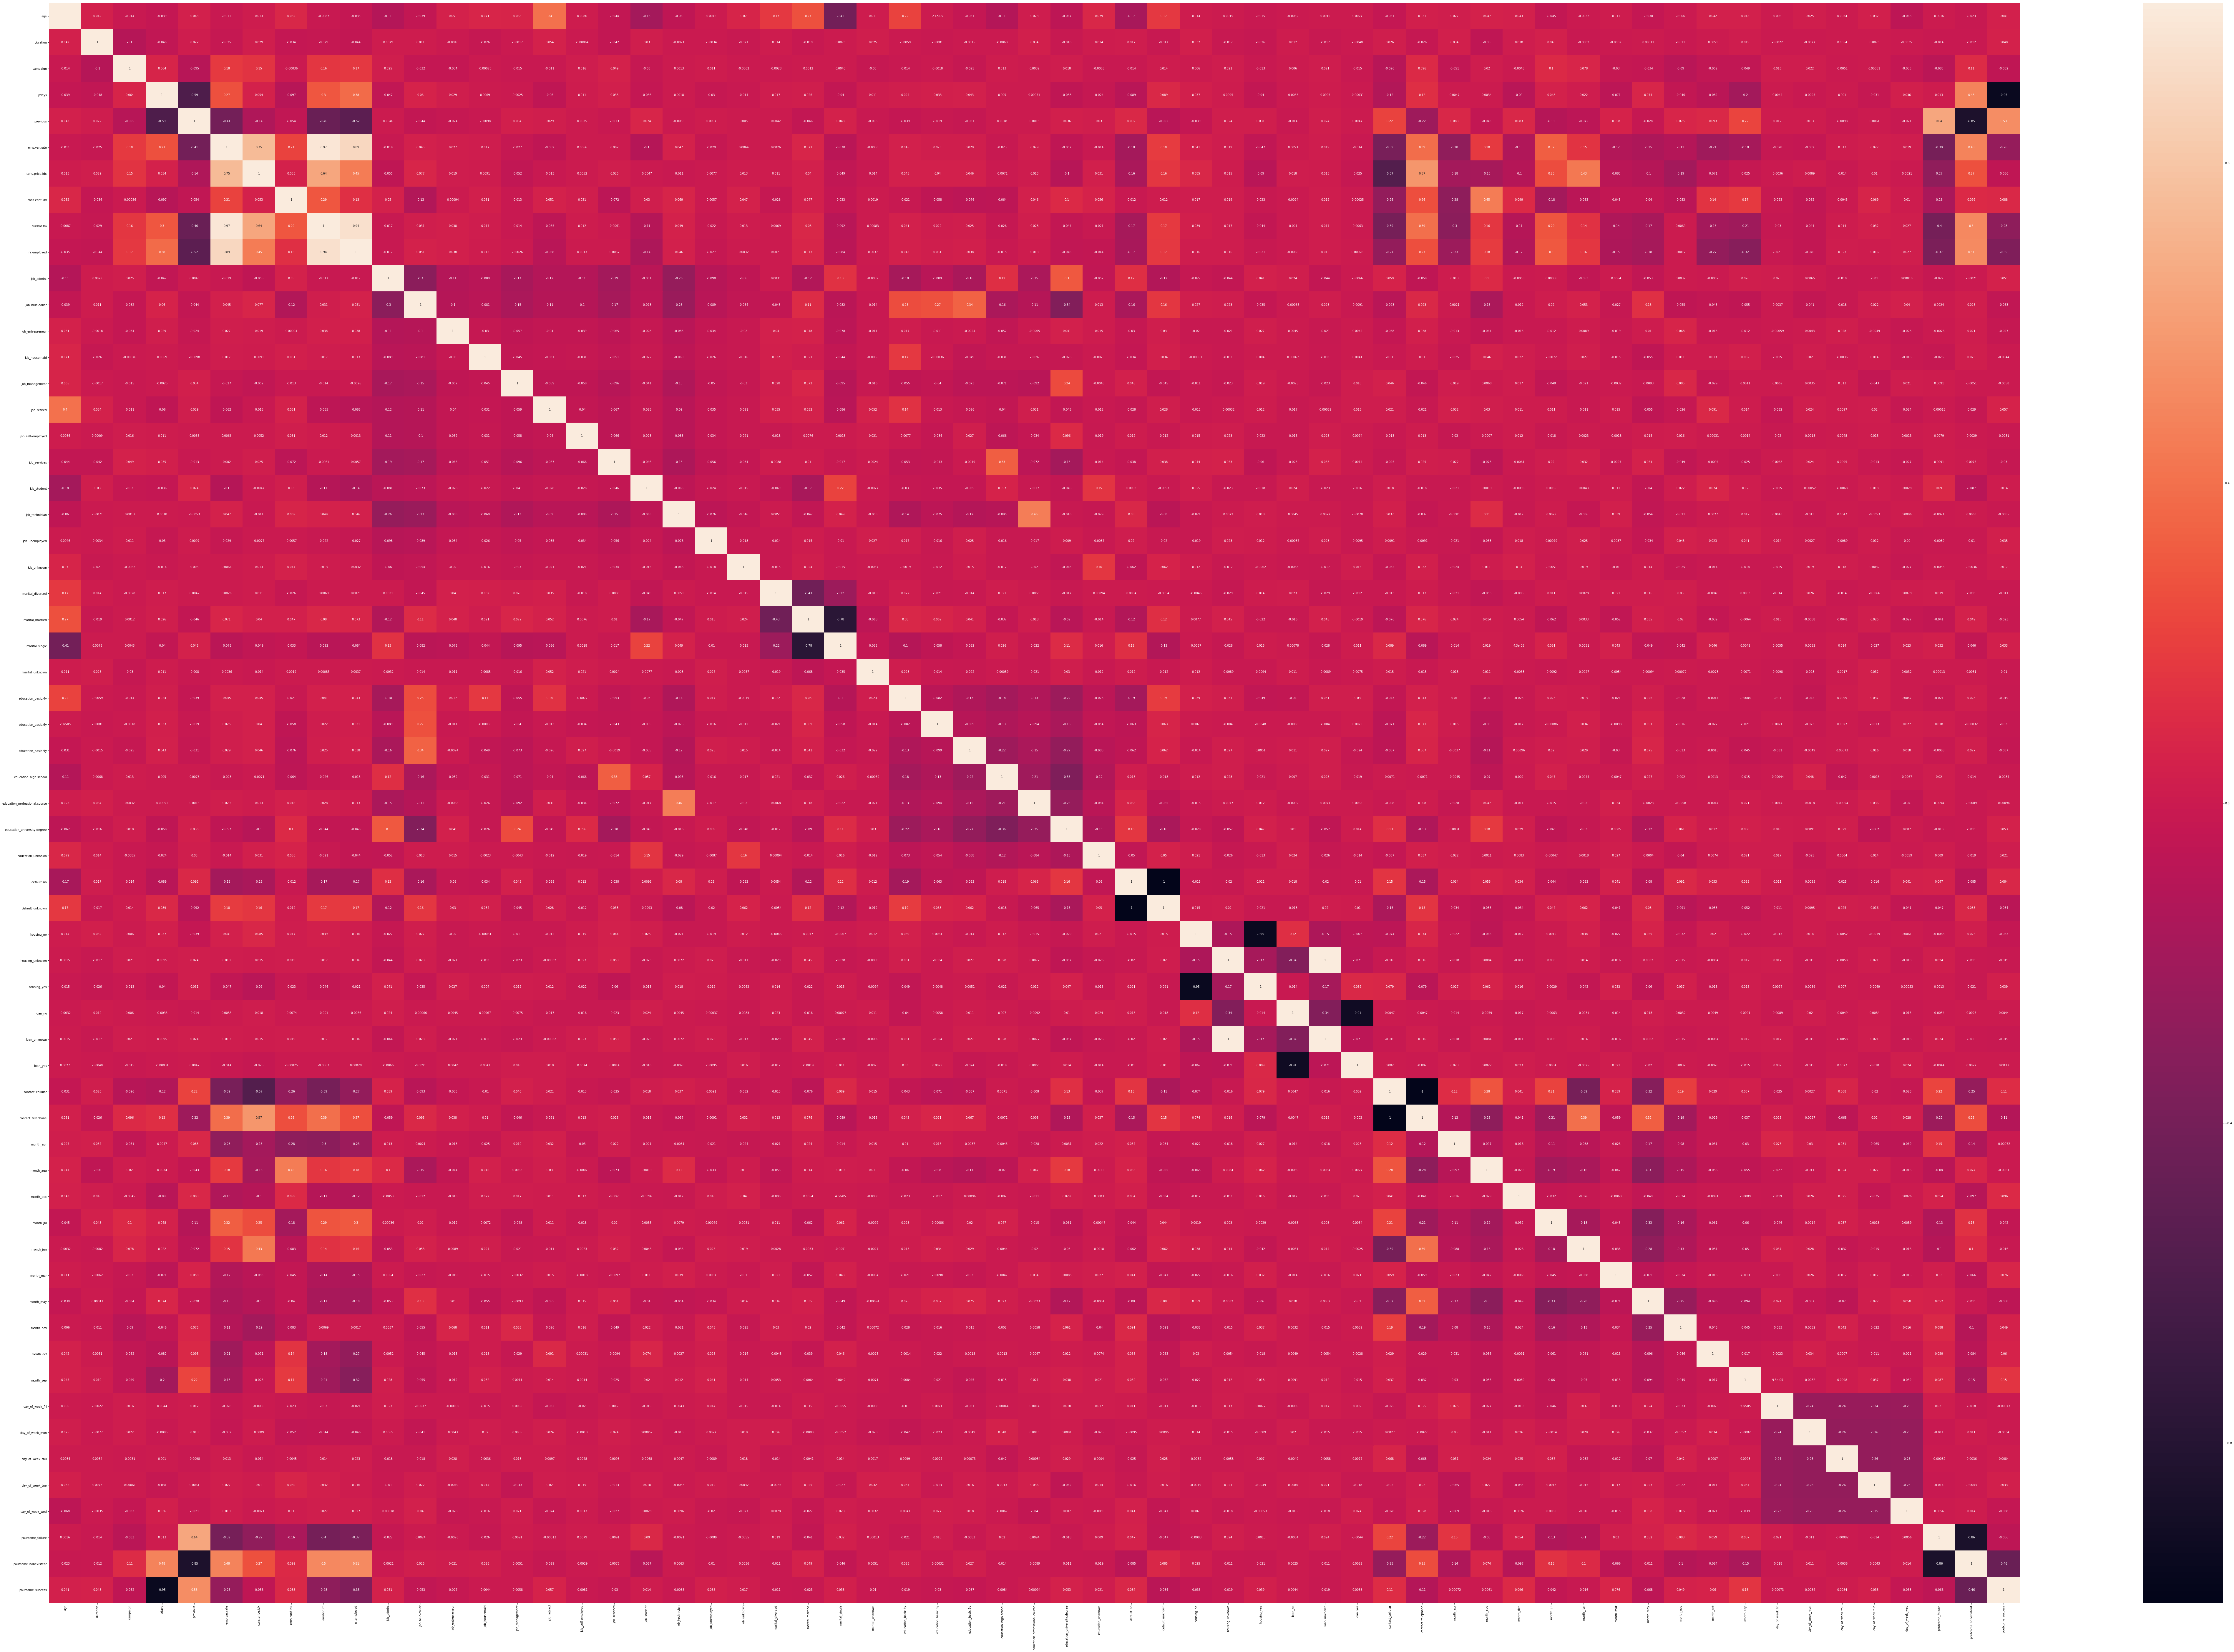

In [5]:
import seaborn as sns #visualização dos dados
plt.figure(figsize=(150, 100))
fig = sns.heatmap(df_2.corr(), annot=True)

Podemos observar que hay muchos atributos que no presentan similitud o disimilitud, estos atributos no son interesantes, buscamos los colores más oscuros o los más claros, ya que estos indican que ambos atributos tienen alguna relación y es esta relación la que tenemos que descubrir.    

In [6]:
dado = df_2[[ 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'contact_telephone', 'contact_cellular']].copy()

**Podemos visualizar una vez más la matriz de similitud, para observar si los atributos elegidos están relacionados**

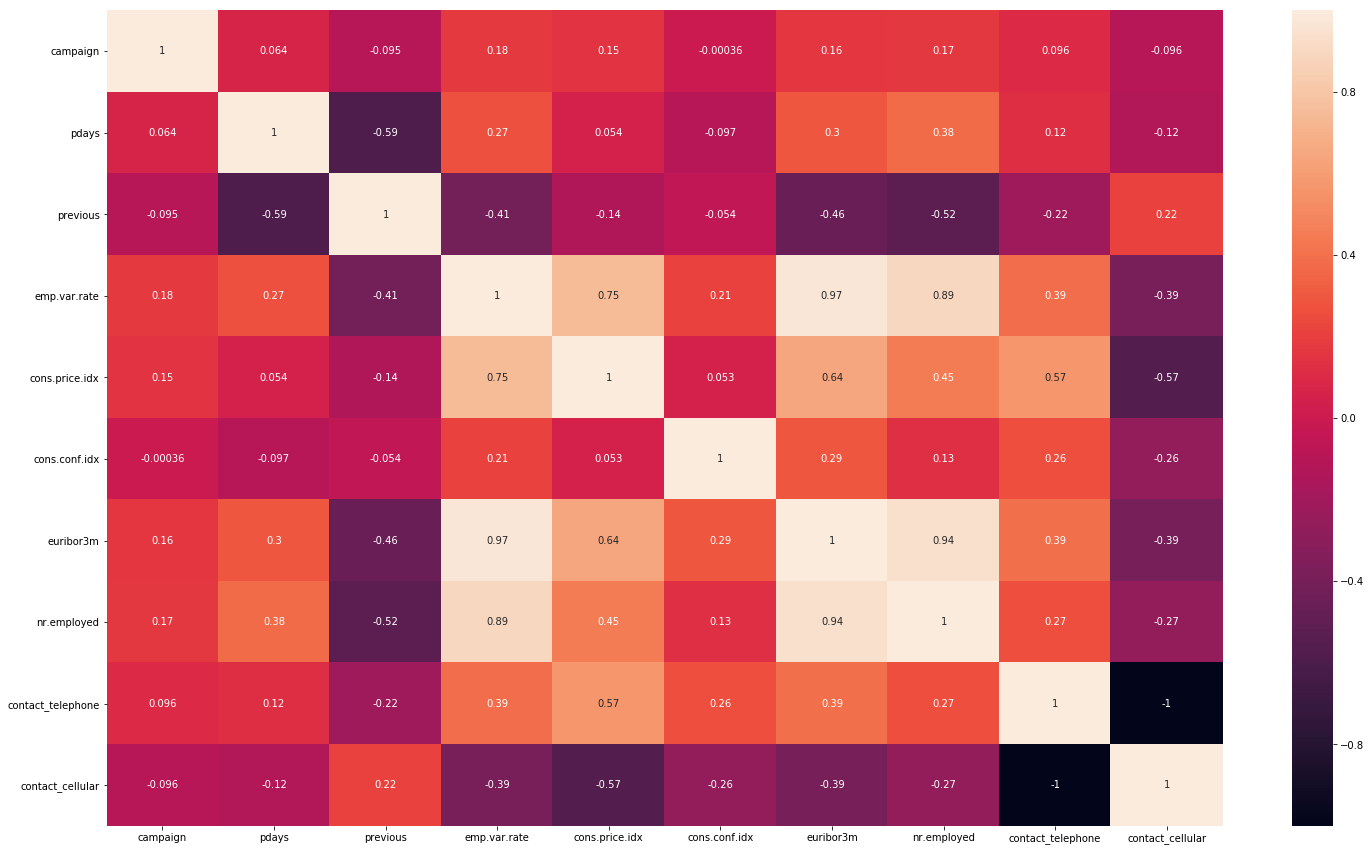

In [7]:
plt.figure(figsize=(25, 15))
fig = sns.heatmap(dado.corr(), annot=True)

Una forma de observar cómo se correlacionan los datos es a partir de un dedograma, que se puede construir con un algoritmo jerárquico, como podemos ver a continuación.


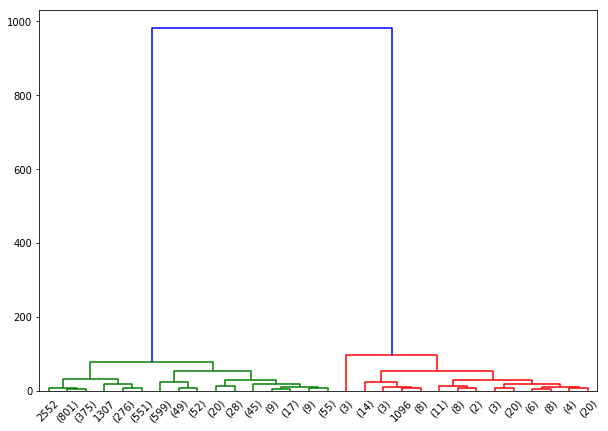

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(dado, 'single')# chama objeto do algoritmo hierarquico
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp' ,orientation='top', distance_sort='descending', show_leaf_counts=True)# plot dedograma
plt.show()

Como podemos observar en el dedograma anterior, hay dos clases que predominan en los datos, lo que indica dos conglomerados.

Con esta información y procesamiento de datos podemos comenzar a crear motores de aprendizaje automático, para esta parte usaremos la biblioteca Sklearn.

In [9]:
from sklearn.cluster import  KMeans, DBSCAN, AgglomerativeClustering

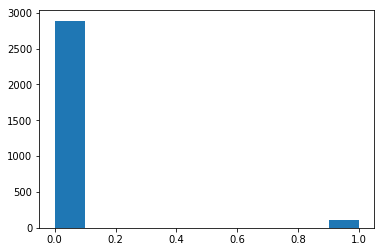

In [10]:
kmeans = KMeans(n_clusters=2).fit(dado)
plt.hist(kmeans.labels_)
plt.show()

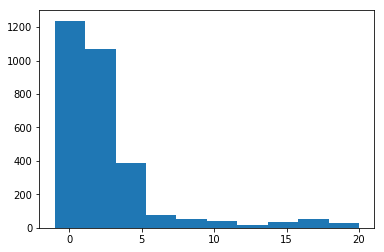

In [11]:
dbs = DBSCAN(eps=2).fit(dado) #Onde eps é a disntância máxima que um objeto pode estãr do outro
plt.hist(dbs.labels_)
plt.show()

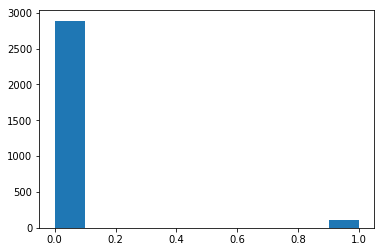

In [12]:
agrupamento = AgglomerativeClustering( n_clusters=2, linkage='complete', affinity='l1').fit_predict(dado)
plt.hist(agrupamento)
plt.show()

   
Como podemos observar, de los tres algoritmos observados, dos tenían una clasificación similar.Una forma de tener una métrica de agrupamiento es a partir del Ancho de la silueta.
    Cada clúster tiene una silueta, esto nos permite ver qué objetos están dentro del clúster y cuáles están en una posición intermedia.

**Ancho de silueta promedio**

Usando el ancho promedio de silueta, podemos tener una métrica de qué tan bien se agrupan nuestros datos, esta técnica calcula la distancia promedio de los objetos en relación con su grupo y el grupo más cercano.

Los valores negativos indican que los objetos están más cerca del clúster vecino que del propio, por lo que debemos evitar estos valores. Los números positivos indican que está cerca de su propio clúster, lo cual es deseable, los valores de salida de este método variarán entre 1 y -1.

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

In [14]:
matriz_distance = euclidean_distances(dado)
matriz_distance[0] #Um exemplo

array([  0.        ,  92.5733113 , 129.187408  , ..., 135.55310853,
        96.85632875, 107.80133664])

In [15]:
# Utilizando o resultado do algoritmo Kmeans com k =2 
silhouette_score(matriz_distance, kmeans.labels_)

0.9357712298556633

In [16]:
#Uilizando o resultado do algoritmo DBSCSN com eps = 2
silhouette_score(matriz_distance, dbs.labels_)

0.6510251956304561

In [17]:
#Uilizando o resultado do algoritmo AgglomerativeClustering c
silhouette_score(matriz_distance, agrupamento)

0.9357712298556633

Con este método podemos basarnos para tener una idea de cómo se está comportando la agrupación, en este caso el algoritmo Kmenas y el Aglomerativo fueron los que mejor resultado tuvieron, idénticos por cierto.

In [18]:
work_data = df.copy() 
work_data['y'] = kmeans.labels_ 

acimda_de_60 = work_data[df['age'] > 60] 

confiavel_60 = acimda_de_60['age'][acimda_de_60['y'] == 1]
nao_confiavel_60 = acimda_de_60['age'][acimda_de_60['y'] == 0] 

In [19]:
abaixo_de_60 = work_data[df['age'] < 60] 

confiavel_menor_60 = abaixo_de_60['age'][abaixo_de_60['y'] == 1]
nao_confiavel_menor_60= abaixo_de_60['age'][abaixo_de_60['y'] == 0]

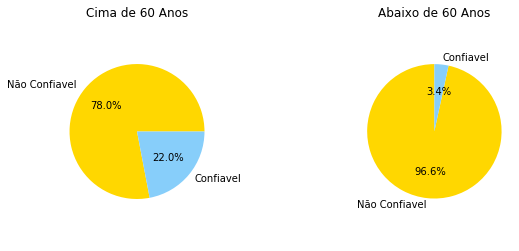

In [20]:

fig, eixos = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

pie_1 = eixos[0].pie([len(nao_confiavel_60), len(confiavel_60)], labels=['Não Confiavel ','Confiavel'],
                    autopct='%1.1f%%', colors=['gold', 'lightskyblue'])

eixos[0].set_title('Cima de 60 Anos')

eixos[0].axis('equal')

pie_2 = eixos[1].pie([len(nao_confiavel_menor_60), len(confiavel_menor_60)], labels=['Não Confiavel','Confiavel'], 
                    autopct='%1.1f%%', startangle=90, colors=['gold', 'lightskyblue'])
eixos[1].set_title('Abaixo de 60 Anos')
plt.axis('equal')

plt.subplots_adjust(wspace=1)
plt.show()

Como podemos ver, la tasa de confianza en prestar dinero a personas menores de 60 años es muy superior a la de personas mayores de 60 años. Podemos interpretar esto observando que los trabajadores de mediana edad todavía tienen largos años de producción, por lo que tienen una mayor probabilidad de pagar la deuda.

Otro punto que podemos plantear es que los mayores tienen más posibilidades de acabar muriendo y endeudándose con ellos que un joven o un padre de familia.